# Montamos Unidad de Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Colab Notebooks/TP_Ind4

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/TP_Ind4'
/content


In [3]:
%cd drive/MyDrive/TP_Ind4

/content/drive/.shortcut-targets-by-id/17FeAVfVLm-bhQ0cBKXS7bsPk0E6kXi_t/TP_Ind4


In [4]:
%ls

 AnalisisExploratorio.ipynb
 data/
 Docs.gdoc
'model tunning'/
'TP 1 - Exploración, visualización de datos y Machine Learning.pdf'


# Paquetes

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [7]:
# Importamos el set de entrenamiento.
train = pd.read_csv("data/Train.csv", index_col=0)

In [8]:
train.shape

(33908, 35)

In [9]:
# Separamos entre variables explicativas y respuesta.
X_train = train.drop('Subscription', axis = 1)
y_train = train['Subscription']

In [10]:
scaler = StandardScaler()

pca = PCA(n_components=None,
          random_state=28)

In [11]:
X_train_s = scaler.fit_transform(X_train)

In [12]:
pca.fit(X_train_s)

PCA(random_state=28)

In [13]:
X_train_pca = pca.transform(X_train_s)

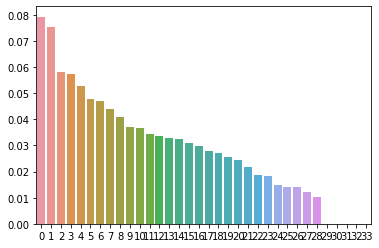

In [14]:
sns.barplot(x = np.arange(pca.n_components_),
            y = pca.explained_variance_ratio_)

In [15]:
pd.DataFrame({'Component':np.arange(pca.n_components_),
              'Var':np.round(pca.explained_variance_ratio_,3),
              'Var Acum':np.cumsum(np.round(pca.explained_variance_ratio_,3))}).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
Component,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000,33.000
Var,0.079,0.076,0.058,0.057,0.053,0.048,0.047,0.044,0.041,0.037,0.037,0.034,0.034,0.033,0.032,0.031,0.030,0.028,0.027,0.025,0.024,0.022,0.019,0.018,0.015,0.014,0.014,0.012,0.010,0.000,0.000,0.000,0.000,0.000
Var Acum,0.079,0.155,0.213,0.270,0.323,0.371,0.418,0.462,0.503,0.540,0.577,0.611,0.645,0.678,0.710,0.741,0.771,0.799,0.826,0.851,0.875,0.897,0.916,0.934,0.949,0.963,0.977,0.989,0.999,0.999,0.999,0.999,0.999,0.999


## Optimization Function

Generamos la función de profit para optimizar los hiperparámetros.

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer

def profit_mean(y_true, y_pred):
  mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  n = len(y_true)
  prof = 250 * mat[1,1] - 50 * mat[0,1] - 25 * mat[1,0]
  return prof/n

In [17]:
profit_mean_score = make_scorer(profit_mean, greater_is_better=True)

## A tener en cuenta
Cuando tuneamos un modelo:
* **Siempre** incluir todos sus **hiperparámetros en el grid**, aunque sea con el valor default. Esto hace que el dataframe que generamos con los resultados tenga toda la información y, si después queremos tunear un hiperparámetro que no habíamos tuneado, **no se agrega una nueva columna**.
* **Siempre** incluir el *train score* para ver si tenemos overfitting, comparando con el resultado de test.

In [40]:
# Grid de valores de hiperparámetros.
logistic_grid = {'penalty':['l2'],
                 'C': np.arange(1,1000,25),
                 'class_weight':[{1: w} for w in np.arange(5,10,0.1)]}

In [41]:
# Hiperparámetros fijos del modelo entrenado.
logistic = LogisticRegression(n_jobs=-1,
                              max_iter=10000,
                              random_state=65)

In [ ]:
time_start = time.time()

# Grid Search
logistic_cv = GridSearchCV(logistic, logistic_grid, cv = 5, scoring=profit_mean_score, verbose=4, n_jobs=-1, return_train_score=True, refit=True)

# Randomized Search
#svm_cv = RandomizedSearchCV(svm, svm_grid, n_iter = 500, cv = 10, scoring='accuracy', verbose=10, n_jobs=-1, random_state=354)

#logistic_cv.fit(X_train_pca[:,1:20], y_train.values.ravel())
logistic_cv.fit(X_train_s, y_train.values.ravel())

# Generamos y mostramos un Dataframe con los resultados del GridSearch
logistic_cv_results = pd.DataFrame(logistic_cv.cv_results_)
print(logistic_cv_results.head(10))

# Generamos un csv con los resultados para el modelo.
#logistic_cv_results.to_csv('model tunning/Logistic/Logistic_CVResults.csv')
logistic_cv_results.to_csv('model tunning/Logistic/Logistic_CVResults.csv', mode='a', header=False)

# Imprimimos el tiempo total de duración de Cross-Validation.
time_finish = time.time()
print(f'Duración {round(time_finish - time_start, 5)} segundos')
print(f'Duración {round((time_finish - time_start)/60, 5)} minutos')

In [32]:
logistic_cv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1120,0.173584,0.050210,0.003815,0.001325,551,{1: 6.999999999999993},l2,"{'C': 551, 'class_weight': {1: 6.9999999999999...",14.851814,14.486877,14.409466,14.083469,15.20056,14.606437,0.384651,1,14.715587,14.715587,14.713743,14.825635,14.633022,14.720715,0.061318
70,0.151865,0.049046,0.003484,0.000466,26,{1: 6.999999999999993},l2,"{'C': 26, 'class_weight': {1: 6.99999999999999...",14.851814,14.486877,14.409466,14.083469,15.20056,14.606437,0.384651,1,14.715587,14.715587,14.713743,14.825635,14.633022,14.720715,0.061318
1520,0.152567,0.049433,0.003327,0.000651,751,{1: 6.999999999999993},l2,"{'C': 751, 'class_weight': {1: 6.9999999999999...",14.851814,14.486877,14.409466,14.083469,15.20056,14.606437,0.384651,1,14.715587,14.715587,14.713743,14.825635,14.633022,14.720715,0.061318
570,0.152505,0.048658,0.003338,0.000595,276,{1: 6.999999999999993},l2,"{'C': 276, 'class_weight': {1: 6.9999999999999...",14.851814,14.486877,14.409466,14.083469,15.20056,14.606437,0.384651,1,14.715587,14.715587,14.713743,14.825635,14.633022,14.720715,0.061318
1420,0.172299,0.050123,0.003554,0.000490,701,{1: 6.999999999999993},l2,"{'C': 701, 'class_weight': {1: 6.9999999999999...",14.851814,14.486877,14.409466,14.083469,15.20056,14.606437,0.384651,1,14.715587,14.715587,14.713743,14.825635,14.633022,14.720715,0.061318


# Results

In [33]:
# Importamos los resultados.
results = pd.read_csv('model tunning/Logistic/Logistic_CVResults.csv', index_col = 0)

In [34]:
# Completamos los NAs con 'None'.
results.fillna(value = 'None', inplace = True)

In [35]:
results.sort_values('mean_test_score', ascending = False).drop_duplicates().head(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1656,0.132311,0.041825,0.003622,0.000487,0.00119,{1: 6.4},l2,"{'C': 0.00119, 'class_weight': {1: 6.4}, 'pena...",14.822324,14.626954,14.520053,14.212506,15.130512,14.662470,0.306146,1,14.708214,14.739549,14.716508,14.745457,14.566668,14.695279,0.065782
1600,0.181927,0.042676,0.002738,0.000048,0.00115,{1: 6.4},l2,"{'C': 0.0011500000000000002, 'class_weight': {...",14.829696,14.649071,14.479505,14.219879,15.123138,14.660258,0.306496,2,14.710057,14.706370,14.693468,14.762967,14.539942,14.682561,0.075163
1638,0.173927,0.049626,0.003539,0.000534,0.00118,{1: 6},l2,"{'C': 0.00118, 'class_weight': {1: 6}, 'penalt...",14.763344,14.626954,14.461073,14.345229,15.097331,14.658786,0.261410,3,14.578264,14.682408,14.692546,14.806282,14.542707,14.660441,0.093163
5287,0.134002,0.039873,0.003306,0.000614,0.00378,{1: 6.9},l2,"{'C': 0.0037800000000000004, 'class_weight': {...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.729411,14.698076,14.737706,14.870793,14.669886,14.741174,0.069124
5147,0.155080,0.046696,0.003343,0.000700,0.00368,{1: 6.9},l2,"{'C': 0.00368, 'class_weight': {1: 6.9}, 'pena...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.723881,14.689781,14.727568,14.880930,14.675416,14.739515,0.073441
311,0.218387,0.002347,0.003829,0.000791,0.00381,{1: 6.9},l2,"{'C': 0.00381, 'class_weight': {1: 6.9}, 'pena...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,1,14.729411,14.698076,14.737706,14.868950,14.661592,14.739147,0.070210
5175,0.197429,0.039340,0.003389,0.000683,0.00370,{1: 6.9},l2,"{'C': 0.0037, 'class_weight': {1: 6.9}, 'penal...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.723881,14.689781,14.727568,14.880930,14.675416,14.739515,0.073441
5329,0.152689,0.048899,0.003182,0.000607,0.00381,{1: 6.9},l2,"{'C': 0.0038100000000000005, 'class_weight': {...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.729411,14.698076,14.737706,14.868950,14.661592,14.739147,0.070210
5189,0.197061,0.040072,0.003455,0.000566,0.00371,{1: 6.9},l2,"{'C': 0.00371, 'class_weight': {1: 6.9}, 'pena...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.725724,14.689781,14.727568,14.880930,14.675416,14.739884,0.073366
5343,0.152384,0.048396,0.003441,0.000520,0.00382,{1: 6.9},l2,"{'C': 0.0038200000000000005, 'class_weight': {...",14.873931,14.549543,14.486877,14.216192,15.163693,14.658047,0.328205,4,14.729411,14.698076,14.737706,14.868950,14.661592,14.739147,0.070210


In [36]:
px.scatter(data_frame=results,
           x = 'param_C',
           y = 'mean_test_score',
           color = 'param_class_weight',
           template = "plotly_white")